# 다중선형회귀

#### #01. 패키지 준비하기


In [1]:
import sys
sys.path.append('../../')
import helper

from pandas import read_excel, DataFrame, merge
from matplotlib import pyplot as plt
import seaborn as sb
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.preprocessing import StandardScaler

#### #02. 데이터셋 준비하기

In [2]:
origin = read_excel("https://data.hossam.kr/F02/fish2.xlsx")
origin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56 entries, 0 to 55
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   길이      56 non-null     float64
 1   높이      56 non-null     float64
 2   두께      56 non-null     float64
 3   무게      56 non-null     float64
dtypes: float64(4)
memory usage: 1.9 KB


#### #03. 데이터 전처리

결측치 확인

In [3]:
origin.isna().sum()

길이    0
높이    0
두께    0
무게    0
dtype: int64

#### #04. 탐색적 데이터 분석

기본통계 확인

In [4]:
origin.describe()

,길이,높이,두께,무게
count,56.000000,56.000000,56.000000,56.000000
mean,27.892857,7.862143,4.745536,382.239286
std,9.021668,2.878343,1.775006,347.617717
min,8.400000,2.110000,1.410000,5.900000
25%,21.825000,5.690000,3.520000,120.000000
50%,25.300000,6.920000,4.155000,207.500000
75%,36.625000,10.850000,6.450000,692.500000
max,44.000000,12.800000,8.140000,1100.000000


> ###### 평균의 차이가 크기 때문에 표준화가 필요해 보인다.

상자그림

In [5]:
plt.rcParams["font.family"] = 'Malgun Gothic'
plt.rcParams["font.size"] = 16
plt.rcParams['axes.unicode_minus'] = False

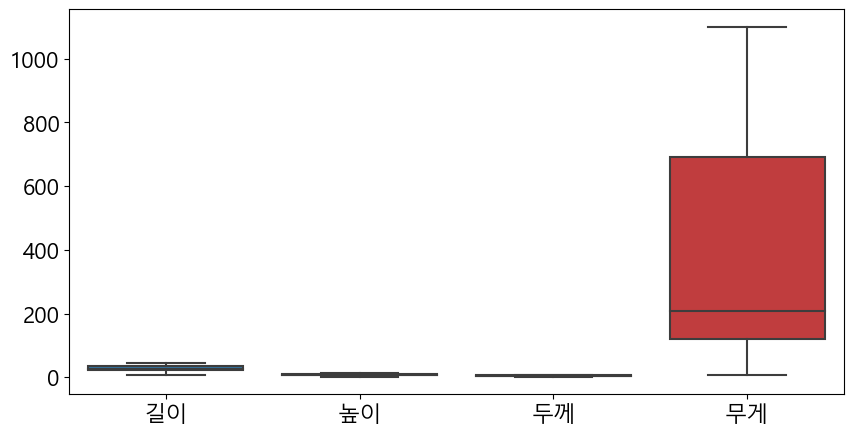

In [6]:
plt.figure(figsize=(10,5))
sb.boxplot(data=origin)
plt.show()
plt.close()

> ###### 데이터의 분포가 상이하므로 표준화가 필요해 보인다.

산점도 그래프와 추세선 확인

c:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 3000x3000 with 0 Axes>

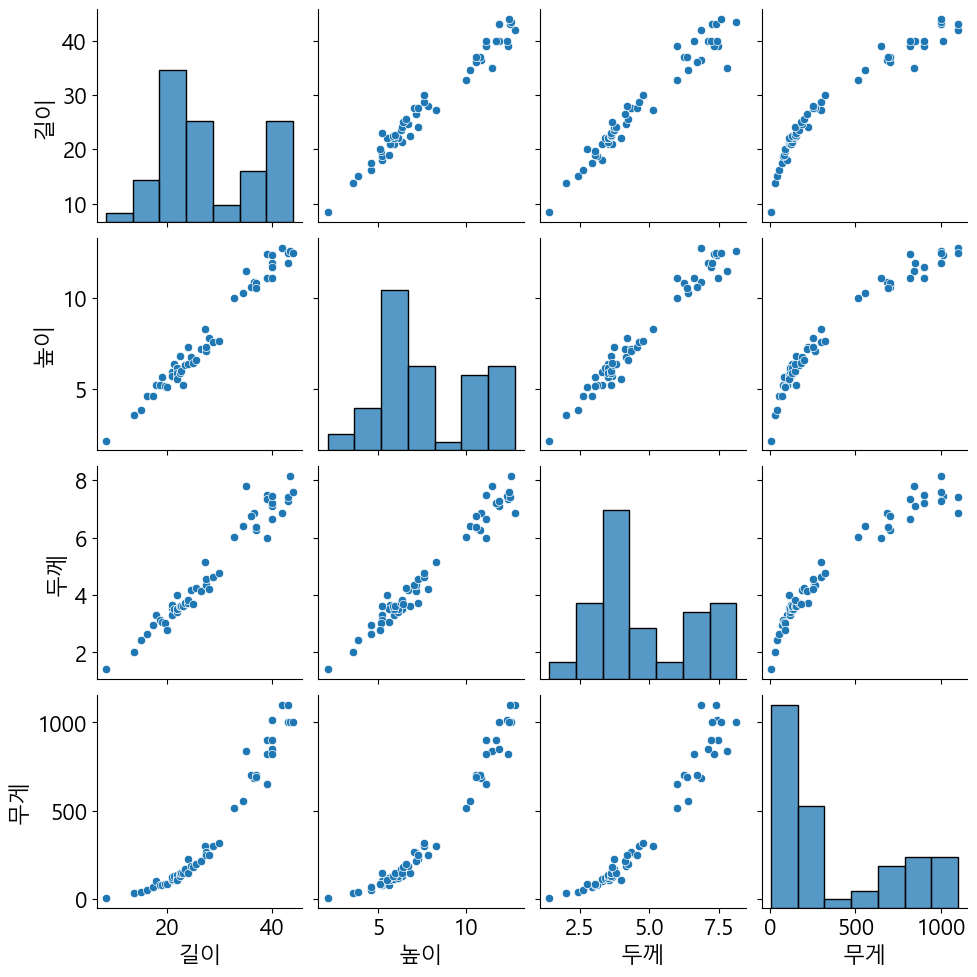

In [7]:
plt.figure(figsize=(30,30))
sb.pairplot(origin)
plt.show()
plt.close()

> ###### 다중공선성이 발생할 것으로 보이고, 선형회귀보다는 다항회귀가 더 적합해 보이지만 예제를 위해 다항선형회귀로 진행하기로 함

#### #05. 데이터셋 분할하기

랜덤시드 고정

In [8]:
np.random.seed(777)

훈련 데이터(독립변수)와 레이블(종속변수) 구분하기

In [9]:
x = origin[['길이', '높이', '두께']]
y = origin[['무게']]
x.shape, y.shape

((56, 3), (56, 1))

데이터 표준화

In [10]:
x_scaller = StandardScaler()
x_scale = x_scaller.fit_transform(x)
y_scaller = StandardScaler()
y_scale = y_scaller.fit_transform(y)
x_scale.shape, y_scale.shape

((56, 3), (56, 1))

표준화 전 후 상자그림 비교

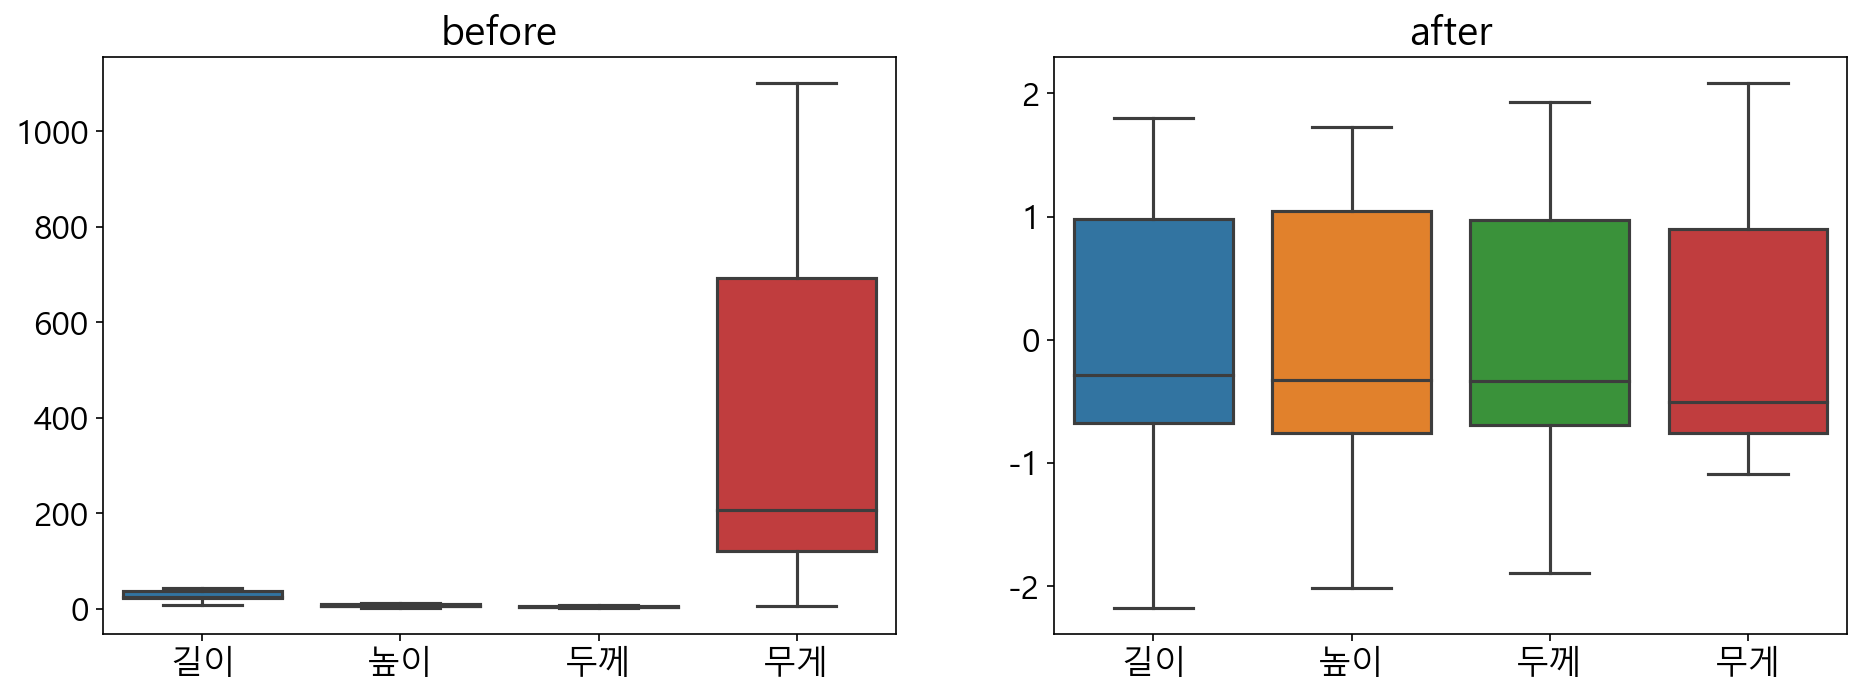

In [11]:
# 임시로 독립변수와 종속변수를 하나의 DataFrame으로 병합
x_scale_df = DataFrame(x_scale, columns=['길이','높이','두께'])
y_scale_df = DataFrame(y_scale, columns=['무게'])
tmp = merge(x_scale_df, y_scale_df, left_index=True, right_index=True)

fig, ax = plt.subplots(1, 2, figsize=(15, 5), dpi=150)
sb.boxplot(data=origin, ax=ax[0])
sb.boxplot(data=tmp, ax=ax[1])
ax[0].set_title('before')
ax[1].set_title('after')
plt.show()
plt.close()

훈련 데이터와 검증 데이터로 분할

In [12]:
x_train, x_test, y_train, y_test = train_test_split(x_scale, y_scale, test_size=0.3, random_state=42)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((39, 3), (17, 3), (39, 1), (17, 1))

#### #06. 모델 개발

모델 정의

데이터가 단순하고 개수가 적다면 과대적합이 발생할 확률이 높기 때문에 주의하면서 적절한 크기의 모델층을 쌓아야 한다.

In [13]:
model = Sequential()
# 1차원의 데이터를 입력으로 받고, 64개의 출력을 가지는 첫 번째 Dense 층
model.add(Dense(64, activation='relu', input_shape=(len(x_train[0]), )))
model.add(Dense(32, activation='relu'))

# 하나의 값을 출력 정답의 범위가 정해지지 않기 때문에 활성화 함수는 linear
model.add(Dense(1, activation='linear'))

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                256       
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2369 (9.25 KB)
Trainable params: 2369 (9.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


학습하기

In [14]:
result = model.fit(x_train, y_train, epochs=500, validation_data=(x_test, y_test), callbacks=[
    EarlyStopping(monitor='val_loss', patience=10, verbose=1),
    ReduceLROnPlateau(monitor= "val_loss", patience=3, factor = 0.5, min_lr=0.001, verbose=1)
])

Epoch 1/500


2/2 [==============================] - 1s 145ms/step - loss: 1.2256 - mae: 0.9421 - val_loss: 0.6893 - val_mae: 0.6874 - lr: 0.0010
Epoch 2/500
2/2 [==============================] - 0s 25ms/step - loss: 1.0315 - mae: 0.8508 - val_loss: 0.5540 - val_mae: 0.5980 - lr: 0.0010
Epoch 3/500
2/2 [==============================] - 0s 24ms/step - loss: 0.8664 - mae: 0.7612 - val_loss: 0.4419 - val_mae: 0.5142 - lr: 0.0010
Epoch 4/500
2/2 [==============================] - 0s 24ms/step - loss: 0.7147 - mae: 0.6731 - val_loss: 0.3515 - val_mae: 0.4482 - lr: 0.0010
Epoch 5/500
2/2 [==============================] - 0s 25ms/step - loss: 0.5858 - mae: 0.5868 - val_loss: 0.2822 - val_mae: 0.3946 - lr: 0.0010
Epoch 6/500
2/2 [==============================] - 0s 24ms/step - loss: 0.4664 - mae: 0.5075 - val_loss: 0.2317 - val_mae: 0.3470 - lr: 0.0010
Epoch 7/500
2/2 [==============================] - 0s 24ms/step - loss: 0.3723 - mae: 0.4386 - val_loss: 0.1954 - val_mae: 0.3152 - lr: 0.0010
Epoch 8/50

#### #07. 학습 결과 평가

In [15]:
# 학습결과
result_df = DataFrame(result.history)
result_df['epochs'] = result_df.index+1
result_df.set_index('epochs', inplace=True)
result_df

,loss,mae,val_loss,val_mae,lr
epochs,,,,,
1,1.225592,0.942066,0.689330,0.687429,0.001
2,1.031535,0.850771,0.553996,0.597990,0.001
3,0.866381,0.761172,0.441867,0.514225,0.001
4,0.714684,0.673128,0.351518,0.448222,0.001
5,0.585814,0.586802,0.282188,0.394576,0.001
...,...,...,...,...,...
138,0.020856,0.100931,0.006859,0.051522,0.001
139,0.020505,0.100446,0.006830,0.050837,0.001
140,0.019988,0.099679,0.006610,0.049792,0.001


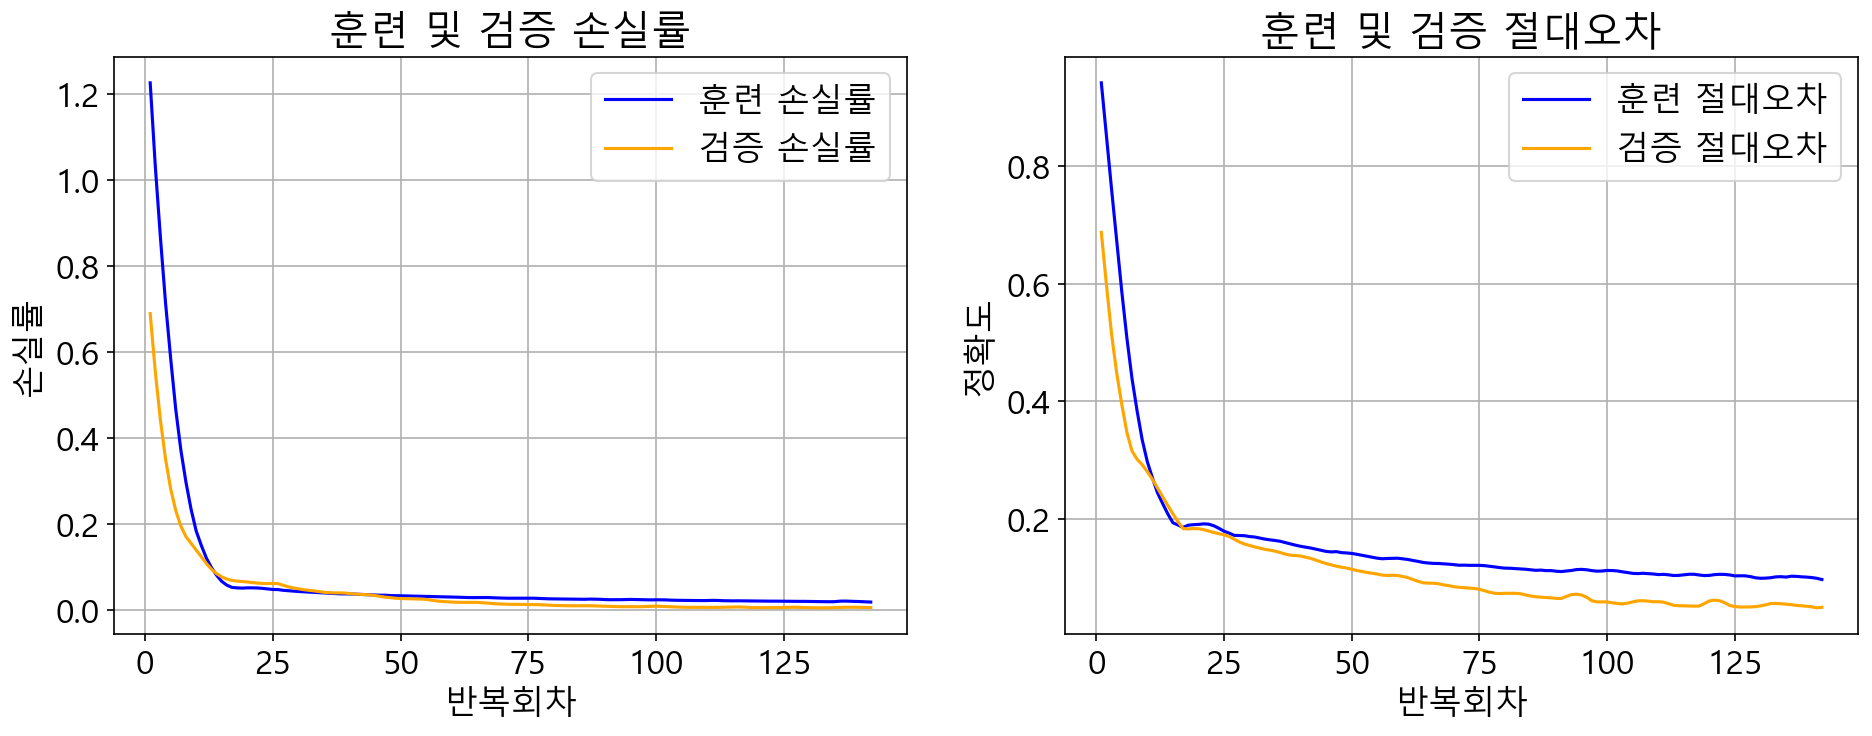

In [16]:
# 그래프 기본 설정
# ----------------------------------------
plt.rcParams["font.family"] = 'Malgun Gothic'
plt.rcParams["font.size"] = 16
plt.rcParams['axes.unicode_minus'] = False

# 그래프를 그리기 위한 객체 생성
# ----------------------------------------
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), dpi=150)

# 1) 훈련 및 검증 손실 그리기
# ----------------------------------------
sb.lineplot(x=result_df.index, y='loss', data=result_df, color='blue', label='훈련 손실률', ax=ax1)
sb.lineplot(x=result_df.index, y='val_loss', data=result_df, color='orange', label='검증 손실률', ax=ax1)
ax1.set_title('훈련 및 검증 손실률')
ax1.set_xlabel('반복회차')
ax1.set_ylabel('손실률')
ax1.grid()
ax1.legend()

# 2) 훈련 및 검증 절대오차 그리기
# ----------------------------------------
sb.lineplot(x=result_df.index, y='mae', data=result_df, color = 'blue', label = '훈련 절대오차', ax=ax2)
sb.lineplot(x=result_df.index, y='val_mae', data=result_df, color = 'orange', label = '검증 절대오차', ax=ax2)
ax2.set_title('훈련 및 검증 절대오차')
ax2.set_xlabel('반복회차')
ax2.set_ylabel('정확도')
ax2.grid()
ax2.legend()

plt.show()
plt.close()

In [17]:
evaluate1 = model.evaluate(x_train, y_train)
print("최종 훈련 손실률: %f, 최종 훈련 절대오차: %f" % (evaluate1[0], evaluate1[1]))
evaluate2 = model.evaluate(x_test, y_test)
print("최종 훈련 손실률: %f, 최종 훈련 절대오차: %f" % (evaluate2[0], evaluate2[1]))

1/2 [==============>...............] - ETA: 0s - loss: 0.0159 - mae: 0.0900

2/2 [==============================] - 0s 4ms/step - loss: 0.0189 - mae: 0.0953
최종 훈련 손실률: 0.018872, 최종 훈련 절대오차: 0.095278
1/1 [==============================] - 0s 20ms/step - loss: 0.0061 - mae: 0.0490
최종 훈련 손실률: 0.006060, 최종 훈련 절대오차: 0.049019


#### #08. 학습결과 적용

예측 결과 산정

In [18]:
train_pred = model.predict(x_train)
test_pred = model.predict(x_test)

1/1 [==============================] - 0s 16ms/step


결과 데이터 셋 구성

In [19]:
train_df = DataFrame(x_train, columns=['길이', '높이', '두께'])
train_df['무게(관측치)'] = y_train.flatten()
train_df['무게(예측치)'] = train_pred.flatten()
train_df['훈련오차'] = train_df['무게(관측치)'] - train_df['무게(예측치)']
train_df.head()

,길이,높이,두께,무게(관측치),무게(예측치),훈련오차
0,-1.173599,-1.147103,-1.026405,-0.906355,-0.908497,0.002142
1,0.906763,0.963306,1.133807,0.922382,0.962087,-0.039704
2,-0.323559,-0.498555,-0.605732,-0.587052,-0.622667,0.035615
3,1.354152,1.426054,1.344143,1.357796,1.467877,-0.110081
4,1.242305,1.601337,1.480578,1.270713,1.523002,-0.252289


In [20]:
test_df = DataFrame(x_test, columns=['길이','높이','두께'])
test_df['무게(관측치)'] = y_test.flatten()
test_df['무게(예측치)'] = test_pred.flatten()

test_df['훈련오차'] = test_df['무게(관측치)']-test_df['무게(예측치)']

test_df.head()

,길이,높이,두께,무게(관측치),무게(예측치),훈련오차
0,-2.180225,-2.016507,-1.896175,-1.092422,-1.300459,0.208037
1,-1.106490,-0.926246,-0.810384,-0.819272,-0.851054,0.031782
2,-0.043940,-0.204080,-0.099788,-0.383859,-0.369816,-0.014042
3,-0.737394,-0.519589,-0.691004,-0.732189,-0.715405,-0.016785
4,-0.603177,-0.701884,-0.639841,-0.732189,-0.714588,-0.017602


In [21]:
train_df.columns

Index(['길이', '높이', '두께', '무게(관측치)', '무게(예측치)', '훈련오차'], dtype='object')

실제 결과값과 머신러닝에 의한 예측값 비교

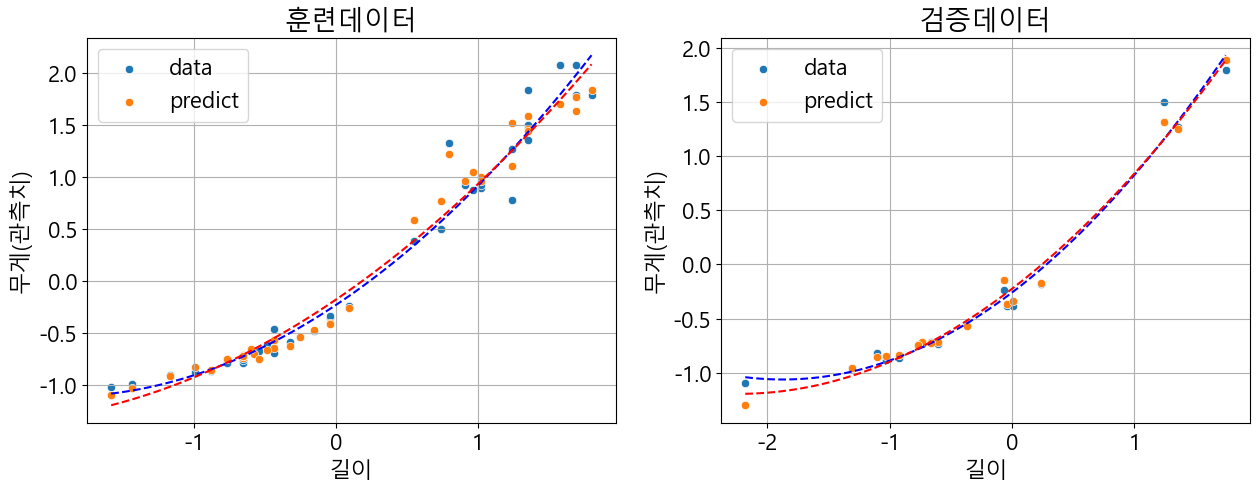

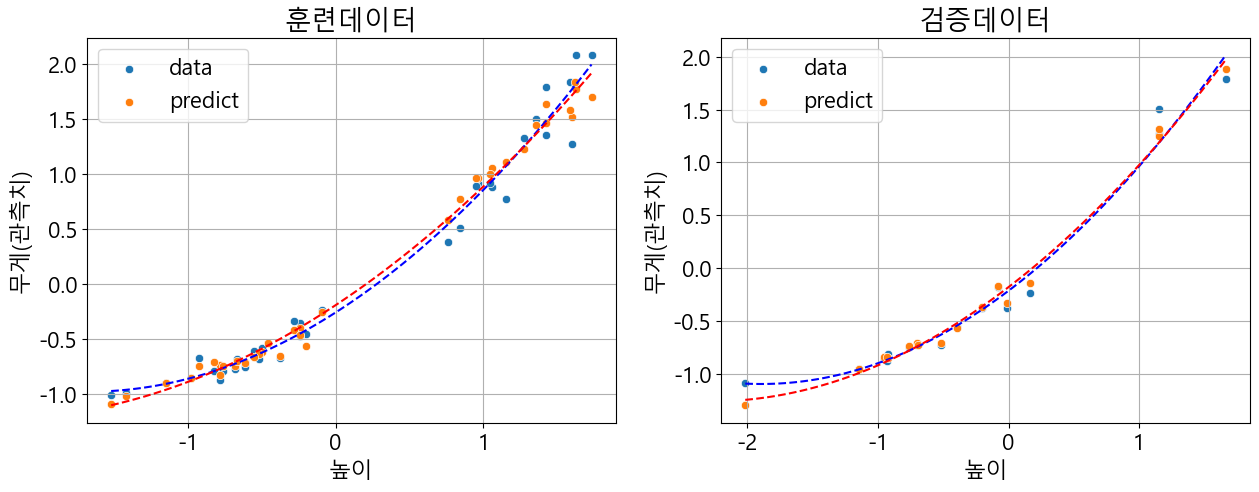

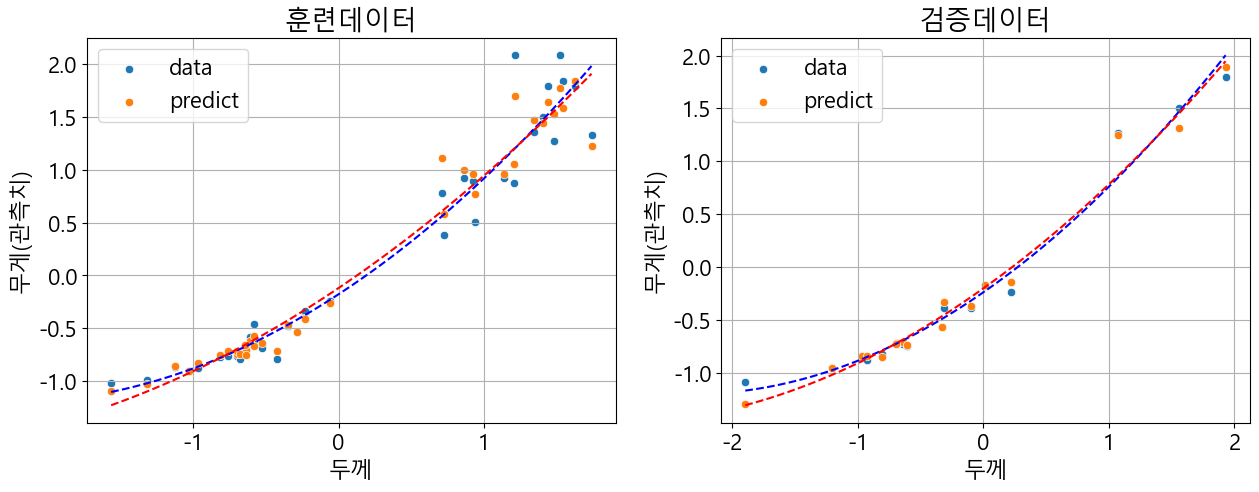

In [22]:
for key in ['길이','높이','두께']:
    helper.regplot(train_df[key], train_df['무게(관측치)'], train_df['무게(예측치)'], "훈련데이터",
                   test_df[key], test_df['무게(관측치)'], test_df['무게(예측치)'], "검증데이터",
                   figsize=(15, 5))

In [23]:
df = read_excel("https://data.hossam.kr/F02/fish2.xlsx")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56 entries, 0 to 55
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   길이      56 non-null     float64
 1   높이      56 non-null     float64
 2   두께      56 non-null     float64
 3   무게      56 non-null     float64
dtypes: float64(4)
memory usage: 1.9 KB


In [24]:
df.isnull().sum()

길이    0
높이    0
두께    0
무게    0
dtype: int64

In [25]:
# 길이    0
# 높이    0
# 두께    0
# 무게    0
df.columns = ['cm', 'height', 'thin', 'kg']

In [26]:
df.head()

,cm,height,thin,kg
0,8.4,2.11,1.41,5.9
1,13.7,3.53,2.00,32.0
2,15.0,3.82,2.43,40.0
3,16.2,4.59,2.63,51.5
4,17.4,4.59,2.94,70.0


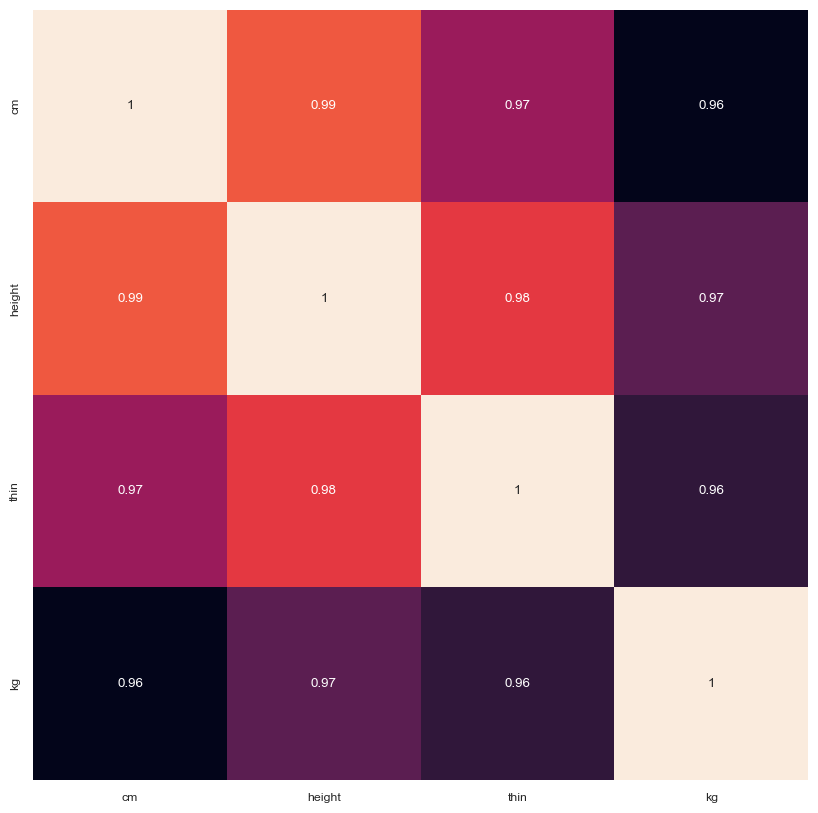

In [27]:
df_corr = df.corr()

#히트맵 그리기
plt.figure(figsize=(10,10))
sb.set(font_scale=0.8)
sb.heatmap(df_corr, annot=True, cbar=False);
plt.show()

In [28]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

df_scaled = df.iloc[:,:]
scaler.fit(df_scaled)
df_scaled = scaler.transform(df_scaled)

#스케일링 변환 된 값을 데이터프레임에 반영
df.iloc[:,:] = df_scaled[:,:]
df.head()

,cm,height,thin,kg
0,0.000000,0.000000,0.000000,0.000000
1,0.148876,0.132834,0.087667,0.023855
2,0.185393,0.159963,0.151560,0.031167
3,0.219101,0.231993,0.181278,0.041678
4,0.252809,0.231993,0.227340,0.058587


In [29]:
from sklearn.model_selection import train_test_split
X_data = df.loc[:,['cm', 'height', 'thin']]
y_data = df.loc[:, 'kg']
x_train, x_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, shuffle=True, random_state=12)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(44, 3) (44,)
(12, 3) (12,)


In [34]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(x_train, y_train)
print("회귀계수(기울기):", np.round(lr.coef_, 1))
print("상수항(절편):", np.round(lr.intercept_, 1))
print("설명력", lr.score(x_train, y_train))
print("설명력", lr.score(x_test, y_test))

회귀계수(기울기): [-0.   0.5  0.6]
상수항(절편): -0.2
설명력 0.9348336507208889
설명력 0.9433604190881071


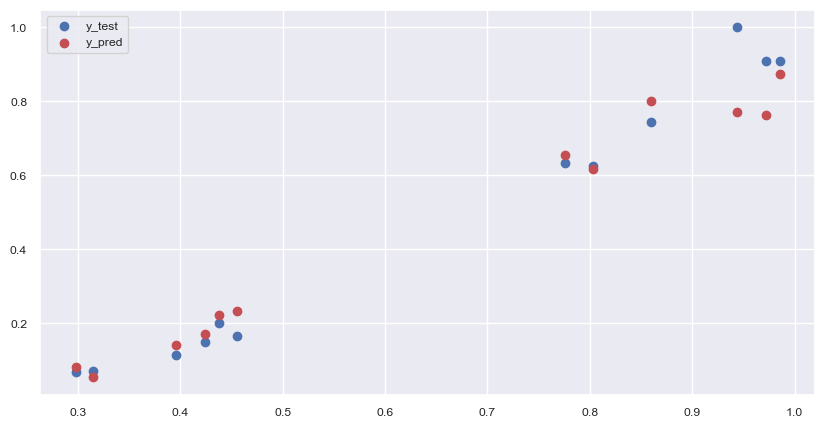

In [31]:
y_test_pred = lr.predict(x_test)

# 예측값 실제값의 분포
plt.figure(figsize=(10,5)) # 그림또는 도표로 나타내기
plt.scatter(x_test['cm'], y_test, label='y_test')
plt.scatter(x_test['cm'], y_test_pred, c='r', label='y_pred')
plt.legend(loc='best')
plt.show()

In [ ]:
# 평가
from sklearn.metrics import mean_squared_error
y_train_pred = lr.predict(x_train)

train_mse = mean_squared_error(y_train, y_train_pred)
print("Train MSE:%3f" % train_mse)

test_mse = mean_squared_error(y_test, y_test_pred)
print("Test MSE: %3f" % test_mse)

Train MSE:0.005656
Test MSE: 0.007109


In [ ]:
# cross_val-score 함수
from sklearn.model_selection import cross_val_score
lr = LinearRegression()
mse_score = -1*cross_val_score(lr, x_train, y_train, cv=5, scoring='neg_mean_squared_error')
print("개별 Fold의 MSE:", np.round(mse_score, 4))
print("평균 MSE:%4f" % np.mean(mse_score))

개별 Fold의 MSE: [0.0036 0.0078 0.006  0.0103 0.005 ]
평균 MSE:0.006535


In [ ]:
from sklearn.preprocessing import PolynomialFeatures
pf = PolynomialFeatures(degree=2)
x_train_poly = pf.fit_transform(x_train)
print("원본 학습 데이터 셋:", x_train.shape) # 2개인 이유 LATST, RM 이 두가지 값을 가지기 때문이고
print("2차 다항식 변환 데이터 셋:", x_train_poly.shape)

원본 학습 데이터 셋: (44, 3)
2차 다항식 변환 데이터 셋: (44, 10)


In [ ]:
# 2차 다항식 변환 데이터셋으로 선형 회귀 모델 모형 학습
lr = LinearRegression()
lr.fit(x_train_poly, y_train) # y_train은 실제 결과값

# 테스트 데이터에 대한 예측 밒 평가
y_train_pred = lr.predict(x_train_poly)
train_mse = mean_squared_error(y_train, y_train_pred)
print("Train MSE:%3f" % train_mse)

x_test_poly = pf.fit_transform(x_test) # 학습한 예측결과랑 test값의 예측 결과 파악
y_test_pred = lr.predict(x_test_poly)
test_mse = mean_squared_error(y_test, y_test_pred)
print("Test MSE:%3f" % test_mse)

Train MSE:0.000552
Test MSE:0.004850


In [ ]:
# 15차 다항식 변환 데이터셋으로 선형 회귀 모형 학습
pf = PolynomialFeatures(degree=15)
x_train_poly = pf.fit_transform(x_train)

lr = LinearRegression()
lr.fit(x_train_poly, y_train)

# 테스트 데이터에 대한 예측 및 평가
y_train_pred = lr.predict(x_train_poly)
train_mse = mean_squared_error(y_train, y_train_pred)
print("Train MSE: %.3f" % train_mse)

x_test_poly = pf.fit_transform(x_test)
y_test_pred = lr.predict(x_test_poly)
test_mse = mean_squared_error(y_test, y_test_pred)
print("Test MSE:%.4f" % test_mse)

Train MSE: 0.000
Test MSE:10484.4320


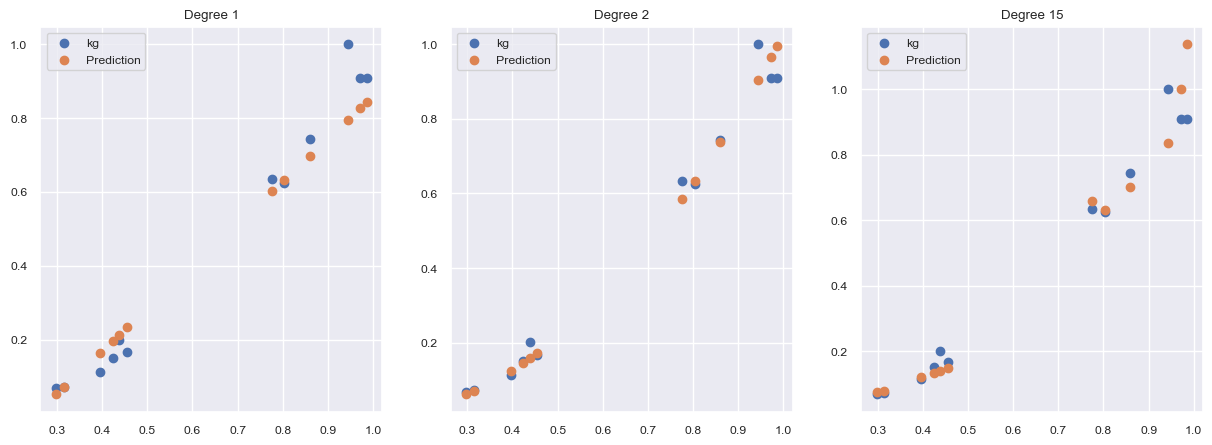

In [ ]:
# 다항식 차수에 따른 모델 적합도 변화
plt.figure(figsize=(15,5))
for n, deg in enumerate([1, 2, 15]):
    axl = plt.subplot(1,3, n+1)
    # plt.axis('off')
    # degree별 다항 회귀 모형 적용
    pf = PolynomialFeatures(degree=deg)
    x_train_poly = pf.fit_transform(x_train.loc[:,['cm']]) # 전채 행 선택후 열의 LSTAT선택 즉, RM제외
    x_test_poly = pf.fit_transform(x_test.loc[:, ['cm']])
    lr = LinearRegression()
    lr.fit(x_train_poly, y_train)
    y_test_pred = lr.predict(x_test_poly)
    # 실제값 분포
    plt.scatter(x_test.loc[:,['cm']], y_test, label='kg')
    # 예측값 분포
    plt.scatter(x_test.loc[:,['cm']], y_test_pred, label='Prediction')
    # 제목 표시
    plt.title("Degree %d" % deg)
    # 범례 표시
    plt.legend()
plt.show()